# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista.

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

In [16]:
retorno_maior_que_0 = df[df['Retorno'] > 0]
retorno_maior_que_0.groupby('categoria', as_index=False).sum(numeric_only=True).drop(columns=['No.', 'Ano', 'Semestre', 'flag_credito'])

,categoria,Valor NF,Créditos,Retorno
0,Alimentos,740053.83,119077.39,2421.400070
1,Auto posto,28757.89,1618.10,20.741733
2,Construção,1360817.25,400935.07,5940.979620
3,Farmácia,449540.98,34510.81,527.281079
4,Mercado,2621589.02,428153.72,4256.089417
5,Restaurantes,558419.91,36184.87,1360.105372
6,Varejo,85029.51,19360.29,296.053142
7,Vestuário,296622.49,74887.07,592.265198
8,não definido,1423035.08,392482.23,5581.548987


## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

In [17]:
df['evento'] = df['Retorno'].apply(lambda x: 1 if x > 0 else 0)

In [18]:
def calc_woe(df, categoria, evento):
    df_woe = df.groupby(categoria).agg({evento: ['sum', 'count']})
    df_woe.columns = ['Eventos', 'Total']
    df_woe['Non-Eventos'] = df_woe['Total'] - df_woe['Eventos']

    df_woe = df_woe[(df_woe['Eventos'] > 0) & (df_woe['Non-Eventos'] > 0)]

    df_woe['Taxa Evento'] = df_woe['Eventos'] / df_woe['Eventos'].sum()
    df_woe['Taxa Non-Evento'] = df_woe['Non-Eventos'] / df_woe['Non-Eventos'].sum()

    df_woe['WOE'] = np.log(df_woe['Taxa Evento'] / df_woe['Taxa Non-Evento'])

    df_woe = df_woe.sort_values(by='WOE')

    return df_woe[['Eventos', 'Total', 'Non-Eventos', 'Taxa Evento', 'Taxa Non-Evento', 'WOE']]

In [21]:
woe = calc_woe(df, 'categoria', 'evento')
woe

,Eventos,Total,Non-Eventos,Taxa Evento,Taxa Non-Evento,WOE
categoria,,,,,,
Auto posto,271,3689,3418,0.003202,0.033182,-2.338269
Varejo,1035,5904,4869,0.012229,0.047268,-1.352064
Farmácia,4886,14940,10054,0.057728,0.097604,-0.525173
Construção,13811,32236,18425,0.163177,0.178870,-0.091820
Restaurantes,17118,39749,22631,0.202250,0.219701,-0.082767
não definido,13042,29861,16819,0.154092,0.163279,-0.057911
Mercado,19808,42695,22887,0.234032,0.222187,0.051940
Vestuário,1799,3612,1813,0.021255,0.017601,0.188671
Alimentos,12868,14960,2092,0.152036,0.020309,2.013046


<ipython-input-22-e2dd0df14b2f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=woe.index, y=woe['WOE'], palette='viridis')


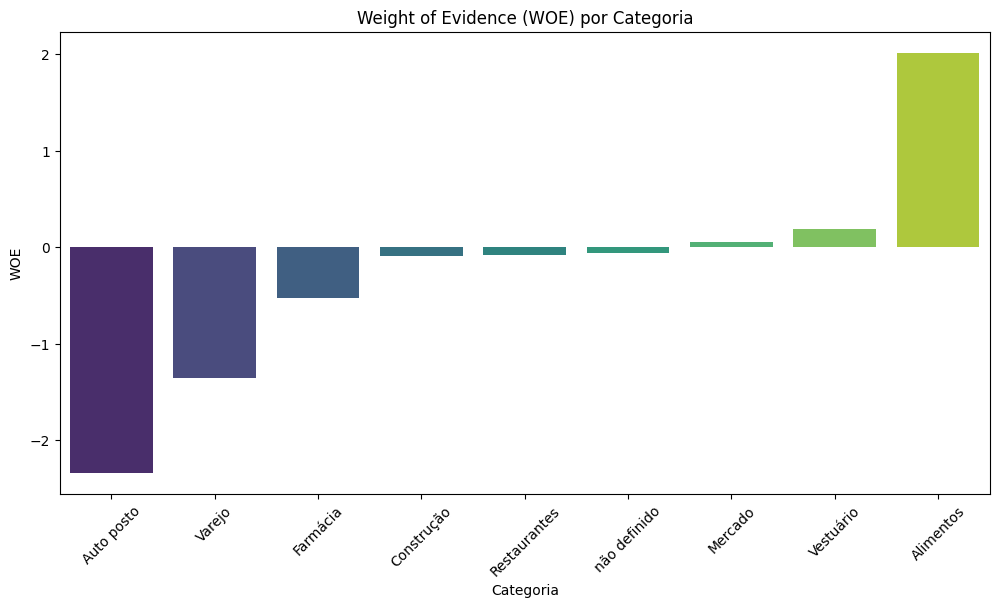

In [22]:
plt.figure(figsize=(12, 6))
sns.barplot(x=woe.index, y=woe['WOE'], palette='viridis')
plt.title('Weight of Evidence (WOE) por Categoria')
plt.xlabel('Categoria')
plt.ylabel('WOE')
plt.xticks(rotation=45)
plt.show()

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [25]:
def calc_iv(df, categoria, evento):
    df_iv = df.groupby(categoria).agg({evento: ['sum', 'count']})
    df_iv.columns = ['Eventos', 'Total']
    df_iv['Non-Eventos'] = df_iv['Total'] - df_iv['Eventos']

    df_iv = df_iv[(df_iv['Eventos'] > 0) & (df_iv['Non-Eventos'] > 0)]

    df_iv['Taxa Evento'] = df_iv['Eventos'] / df_iv['Eventos'].sum()
    df_iv['Taxa Non-Evento'] = df_iv['Non-Eventos'] / df_iv['Non-Eventos'].sum()

    df_iv['WOE'] = np.log(df_iv['Taxa Evento'] / df_iv['Taxa Non-Evento'])
    df_iv['IV'] = (df_iv['Taxa Evento'] - df_iv['Taxa Non-Evento']) * df_iv['WOE']

    iv_total = df_iv['IV'].sum()

    return iv_total

In [26]:
calc_iv(df, 'categoria', 'evento')

0.40831279222730105

## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


<div style="color: blue;">
**Conclusões:**

1. **WOE Positivo:** Indica que a categoria tem uma maior proporção de eventos (retorno > 0).
2. **WOE Negativo:** Indica que a categoria tem uma menor proporção de eventos.
3. **Importância das Categorias:** O cálculo do WOE ajuda a identificar quais categorias são mais importantes para prever o evento de interesse.

Os resultados mostram a distribuição do WOE por categoria, destacando aquelas com maior e menor impacto nos eventos. Podemos perceber que a proporção de emitentes com Retorno > 0 é maior nas categorias de Alimentos e Vestuários, e menor nas categorias de AutoPosto, Varejo e Farmácia
</div>
